## Import packages

In [65]:
import numpy as np 
import csv 
import glob
import pandas as pd
import os
import sys
from tqdm import tqdm
from joblib import Parallel, delayed
import ast
import hssm

# Get the path to the parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the Python path
sys.path.append(parent_dir)

current_dir = os.getcwd()


# Import utils folder
from utils.twostep_support import *    
from models import *
from MLE import *

## Select model, dataset, optimizer and variables

In [66]:
model = "AI" # RL or AI
learning = "PSM" # RL, PSM
mtype = 1
dataset = 'magic_carpet_2020'

In [67]:
# Different model setups
if model == "RL":
    p_names = ["lr1", "lr2", "lam", "b1", "b2", "p", "w"]
    lower_bounds = np.array([0, 0, 0, 0, 0, -1, 0])
    upper_bounds = np.array([1, 1, 1, 20, 20, 1, 1])
elif model == "AI":
    if mtype == 0:
        p_names = ["lr","vunsamp", "vsamp", "vps", "gamma1", "gamma2", "lam", "kappa_a", "prior_r"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0.2])
        upper_bounds = np.array([4, 0.9, 0.9, 0.9, 30, 30, 10, 5, 0.8])
    elif mtype == 1:
        p_names = ["lr","vunsamp", "vps", "gamma1", "gamma2", "lam", "kappa_a", "prior_r"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0, 0, 0.2])
        upper_bounds = np.array([4, 0.9, 0.9, 30, 30, 10, 5, 0.8])
    elif mtype == 2:
        p_names = ["lr", "vsamp", "vps", "gamma1", "gamma2", "lam", "kappa_a", "prior_r"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0, 0, 0.2])
        upper_bounds = np.array([4, 0.9, 0.9, 30, 30, 10, 5, 0.8])
    elif mtype == 3:
        p_names = ["lr","vunsamp", "vsamp", "gamma1", "gamma2", "lam", "kappa_a", "prior_r"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0, 0, 0.2])
        upper_bounds = np.array([4, 0.9, 0.9, 30, 30, 10, 5, 0.8])   

elif model == "AI_ddm":
    if mtype == 0:
        p_names = ["lr","vunsamp", "vsamp", "vps", "lam", "kappa_a", "prior_r", "a", "v_stage_0", "v_stage_1", "t"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0, 0.2, 0.3, 0, 0, 0])
        upper_bounds = np.array([4, 0.9, 0.9, 0.9, 10, 5, 0.8, 2, 10, 10, 1])
    elif mtype == 1:
        p_names = ["lr","vunsamp", "vps","lam", "kappa_a", "prior_r", "a", "v_stage_0", "v_stage_1", "t"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0.2, 0.3, 0, 0, 0])
        upper_bounds = np.array([4, 0.9, 0.9, 10, 5, 0.8, 2, 10, 10, 1])
    elif mtype == 2:
        p_names = ["lr", "vsamp", "vps","lam", "kappa_a", "prior_r", "a", "v_stage_0", "v_stage_1", "t"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0.2, 0.3, 0, 0, 0])
        upper_bounds = np.array([4, 0.9, 0.9, 10, 5, 0.8, 2, 10, 10, 1])
    elif mtype == 3:
        p_names = ["lr","vunsamp", "vsamp", "lam", "kappa_a", "prior_r", "a", "v_stage_0", "v_stage_1", "t"]
        lower_bounds = np.array([0, 0, 0, 0, 0, 0.2, 0.3, 0, 0, 0])
        upper_bounds = np.array([4, 0.9, 0.9, 10, 5, 0.8, 2, 10, 10, 1])


nump = len(p_names) # Parameter names

## Load empirical data

In [68]:
# Path to dataset

current_dir = os.getcwd()

if dataset == 'magic_carpet_2023':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/task_behaviour'))

    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*story.csv"))

if dataset == 'magic_carpet_2020':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/choices'))


    
    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*game.csv"))

    
# Create an empty list to hold the dataframes
df_list = []

par_ids = []

# Loop through each file
for file_path in file_paths:
    # Extract the participant ID from the filename (assuming filename format like 001_story.csv)
    participant_id_str = os.path.basename(file_path).split('_')[0]
    
    participant_id = int(participant_id_str)
    
    par_ids.append(participant_id)
    
    # Read the CSV file into a dataframe
    df = pd.read_csv(file_path)
    
    # Add the ParticipantID column
    df['ParticipantID'] = participant_id
    
    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all dataframes into one
df_empirical_data = pd.concat(df_list, ignore_index=True)


n_par = len(par_ids) # Number of participants

## Data cleaning

In [69]:
if dataset == 'magic_carpet_2020':
    df_empirical_data = df_empirical_data[
        ~(
            ((df_empirical_data['rt1'] < 0.1) | (df_empirical_data['rt1'] == -1)) |
            ((df_empirical_data['rt2'] < 0.1) | (df_empirical_data['rt2'] == -1))
        )
    ]
if dataset == 'magic_carpet_2023':
    df_empirical_data = df_empirical_data[
        ~(
            ((df_empirical_data['rt1'] < 0.1) | (df_empirical_data['rt1'] == "")) |
            ((df_empirical_data['rt2'] < 0.1) | (df_empirical_data['rt2'] == ""))
        )
    ]

## Load fitted parameters

In [70]:
path_to_data = os.path.abspath(os.path.join(current_dir, 
                                           '../model_fitting/fitted_parameters/' + dataset + 
                                            '/fitted_parameters_M' + model + str(mtype) + '.csv'))

df_fitted_parameters = pd.read_csv(path_to_data)

## Helper functions

In [71]:
def KL_dive(p, q):
    """
    KL(p||q)
    Returns the Kullback-Leibler divergence of two Categorical distribution vectors p and q.
    """
    
    return p[0]*np.log(p[0]/q[0]) + p[1]*np.log(p[1]/q[1]) 

In [82]:
def process_participant(params, observations, actions, learning, mtype):
    """
    Evaluate Delta G given a sequence of actions, observations and parameter sets (performed trial-wise).

    ~~~~~~
    INPUTS
    ~~~~~~
    params: model parameters
    observations: sequence of transition and outcome observations
    actions: sequence of taken actions
    learning: learning algorithm used (Default is "PSM": Predictive-surprise modulated learning)
    mtype: integer specifying submodel
    """

    if mtype == 0:
        lr = params['lr']
        vunsamp = params['vunsamp']
        vsamp = params['vsamp']
        vps = params['vps']
        lam = params['lam']
        kappa_a = params['kappa_a']
        prior_nu = 2
        prior_r = params['prior_r']

    #If mtype > 0:
    else: # We set parameters 0, 1, and 2 later, for now the identical parameters for all mtype>0:
        lr = params['lr']
        lam = params['lam']
        kappa_a = params['kappa_a']
        prior_nu = 2
        prior_r = params['prior_r']

        if mtype == 1: # No Decay for Sampled Actions
            vunsamp = params['vunsamp']
            vsamp = 0
            vps = params['vps']
            
        if mtype == 2: # No Decay for UNsampled Actions
            vunsamp = 0
            vsamp = params['vsamp']
            vps = params['vps']

        if mtype == 3: # No Surprise Learning
            vunsamp = params['vunsamp']
            vsamp = params['vsamp']
            vps = 0

    if model == "AI_ddm":
        v_stage_0 = params["v_stage_0"]
        v_stage_1 = params["v_stage_1"]
        a_bs = params["a_bs"]
        ndt = params["ndt"]
    
    if model == "AI":
        gamma1 = params["gamma1"]
        gamma2 = params["gamma2"]

    #### ----------
    # Specify task and generate (potential) observations
    T = observations.shape[0]
    
    task_dict = {  
        "type": "drift",
        "T": T,
        "x": False,
        "r": True,
        "delta": 0.025,
        "bounds": [0.25 ,0.75]
    }

    model_dict = { # Model specification
        "act": 'AI',
        "learn": "PSM",
        "learn_transitions": False,
        "lr": lr,
        "vunsamp": vunsamp,
        "vsamp": vsamp,
        "vps": vps, 
        "lam": lam,
        "kappa_a": kappa_a,
        "prior_r": prior_r
    }

    if model == "AI_ddm": 
        model_dict["gamma1"] = 0
        model_dict["gamma2"] = 0  
    else:
        model_dict["gamma1"] = gamma1
        model_dict["gamma2"] = gamma2 

    temp = models.learn_and_act(task_dict, model_dict)
    
    EFEs = np.ones((T,6))

    po = np.zeros(2)
    pa = np.zeros(2)

    delta_G_0 = np.zeros(T)
    delta_G_1 = np.zeros(T)
    simulated_prob_min_EFE_action_stage_1 = np.zeros(T)   
    empirical_min_EFE_action_stage_1 = np.zeros(T) 
    simulated_prob_min_EFE_action_stage_0 = np.zeros(T)   
    empirical_min_EFE_action_stage_0 = np.zeros(T)
    Gs_stage_0 = np.zeros((T,2)) 
    Gs_stage_1 = np.zeros((T,2)) 
    KL_0 = np.zeros(T)
    KL_1 = np.zeros(T)
    
    if model == "AI_ddm":
        average_simulated_rts_stage_0 = np.zeros(T)
        average_simulated_rts_stage_1 = np.zeros(T)

    prev_a = 0
    prev_EFE_2 = -1
    prev_EFE_3 = -1
    prev_EFE_4 = -1
    prev_EFE_5 = -1
    
    # Check which actions were taken and which outcomes were observed
    for n in range(T):
        po = observations[n,:].astype(int)
        pa = actions[n,:].astype(int)

        Gs = temp.perform_trial_return_EFE(n, pa, po)

        EFEs[n,0] = Gs[n, 0, 0]
        EFEs[n,1] = Gs[n, 0, 1]
        EFEs[n,2] = Gs[n, 1, 0]
        EFEs[n,3] = Gs[n, 1, 1]
        EFEs[n,4] = Gs[n, 2, 0]
        EFEs[n,5] = Gs[n, 2, 1]

        G_0_diff = EFEs[n,0] - EFEs[n,1]

        Gs_stage_0[n,0] = EFEs[n, 0]
        Gs_stage_0[n,1] = EFEs[n, 1]

        # Habits
        E = np.zeros(2)
        if n > 0:
            E[prev_a] += np.exp(kappa_a)
            E[int(1-prev_a)] += np.exp(-kappa_a)
        
        prev_a = pa[0]
        
        if n == 0:
            KL_0[n] = 0
        else: 
            KL_0[n] = KL_dive(np.exp(-EFEs[n,:2])/np.sum(np.exp(-EFEs[n,:2])), np.exp(-E)/np.sum(np.exp(-E)))
        
        observed_tran = observations[n,0]

        if observed_tran == 0:
            G_1_diff = EFEs[n, 2] - EFEs[n, 3]
            Gs_stage_1[n,0] = EFEs[n, 2]
            Gs_stage_1[n,1] = EFEs[n, 3]

            if n == 0:
                KL_1[n] = 0
            else: 
                if prev_EFE_2 == -1 or prev_EFE_3 == -1:
                    KL_1[n] = KL_dive(np.exp(EFEs[n,2:4])/np.sum(np.exp(EFEs[n,2:4])), [0.5,0.5])                
                else:
                    KL_1[n] = KL_dive(np.exp(EFEs[n,2:4])/np.sum(np.exp(EFEs[n,2:4])), np.exp(np.array([prev_EFE_2,prev_EFE_3]))/np.sum(np.exp(np.array([prev_EFE_2,prev_EFE_3]))))
            prev_EFE_2 = EFEs[n,2]
            prev_EFE_3 = EFEs[n,3]
            
        if observed_tran == 1:
            G_1_diff = EFEs[n, 4] - EFEs[n, 5]
            Gs_stage_1[n,0] = EFEs[n, 4]
            Gs_stage_1[n,1] = EFEs[n, 5]
            if n == 0:
                KL_1[n] = 0
            else: 
                if prev_EFE_4 == -1 or prev_EFE_5 == -1:
                    KL_1[n] = KL_dive(np.exp(EFEs[n,4:6])/np.sum(np.exp(EFEs[n,4:6])), [0.5,0.5])           
                else:
                    KL_1[n] = KL_dive(np.exp(EFEs[n,4:6])/np.sum(np.exp(EFEs[n,4:6])), np.exp(np.array([prev_EFE_4,prev_EFE_5]))/np.sum(np.array([prev_EFE_4,prev_EFE_5])))
            prev_EFE_4 = EFEs[n,4]
            prev_EFE_5 = EFEs[n,5]
            
        delta_G_0[n] = abs(G_0_diff)
        delta_G_1[n] = abs(G_1_diff)

        if G_1_diff < 0:
            if actions[n,1] == 0:
                empirical_min_EFE_action_stage_1[n] = 1
        else:
            if actions[n,1] == 1:
                empirical_min_EFE_action_stage_1[n] = 1

        if G_0_diff < 0:
            if actions[n,0] == 0:
                empirical_min_EFE_action_stage_0[n] = 1
        else:
            if actions[n,0] == 1:
                empirical_min_EFE_action_stage_0[n] = 1

        if model == "AI_ddm":
            v0 = v_stage_0*G_0_diff
            v1 = v_stage_1*G_1_diff

            min_EFE_action_chosen = np.zeros(100)
            rts_temp = np.zeros(100)

            for i in range(100):
                param_dict = dict(v=v0, a=a_bs, z=0.5, t=ndt)

                # Simulate trial
                ddm_simulation = hssm.simulate_data(model="ddm", theta=param_dict, size=1,random_state= random.randint(1, 9999999))

                rts_temp[i] = ddm_simulation['rt'].iloc[0]

                response = ddm_simulation['response'].iloc[0] 

                if G_0_diff < 0:
                    if response == -1:
                        min_EFE_action_chosen[i] = 1
                else:
                    if response == 1:
                        min_EFE_action_chosen[i] = 1
                        
            simulated_prob_min_EFE_action_stage_0[n] = np.sum(min_EFE_action_chosen)/100
            average_simulated_rts_stage_0[n] = np.average(rts_temp)

            min_EFE_action_chosen = np.zeros(100)
            rts_temp = np.zeros(100)

            for i in range(100):
                param_dict = dict(v=v1, a=a_bs, z=0.5, t=ndt)

                # Simulate trial
                ddm_simulation = hssm.simulate_data(model="ddm", theta=param_dict, size=1,random_state= random.randint(1, 9999999))

                rts_temp[i] = ddm_simulation['rt'].iloc[0]

                response = ddm_simulation['response'].iloc[0] 

                if G_1_diff < 0:
                    if response == -1:
                        min_EFE_action_chosen[i] = 1
                else:
                    if response == 1:
                        min_EFE_action_chosen[i] = 1
                        
            simulated_prob_min_EFE_action_stage_1[n] = np.sum(min_EFE_action_chosen)/100
            average_simulated_rts_stage_1[n] = np.average(rts_temp)
            
        if model == "AI":

            min_EFE_action_chosen = np.zeros(100)

            Gg = np.clip(-Gs_stage_1[n]  * gamma2,-500,500)
            probs = np.exp(Gg)/np.sum(np.exp(Gg))

            for i in range(100):
                
                response = np.random.choice(np.arange(2),p=probs)
                
                if G_1_diff < 0:
                    if response == 0:
                        min_EFE_action_chosen[i] = 1
                else:
                    if response == 1:
                        min_EFE_action_chosen[i] = 1
                        
            simulated_prob_min_EFE_action_stage_1[n] = np.sum(min_EFE_action_chosen)/100

            min_EFE_action_chosen = np.zeros(100)
        
            Gg = np.clip(-Gs_stage_0[n]  * gamma1,-500,500)
            probs = np.exp(Gg)/np.sum(np.exp(Gg))

            for i in range(100):
                
                response = np.random.choice(np.arange(2),p=probs)
                
                if G_0_diff < 0:
                    if response == 0:
                        min_EFE_action_chosen[i] = 1
                else:
                    if response == 1:
                        min_EFE_action_chosen[i] = 1
                
            simulated_prob_min_EFE_action_stage_0[n] = np.sum(min_EFE_action_chosen)/100
         
    if model == "AI_ddm":       
        return delta_G_0, delta_G_1, simulated_prob_min_EFE_action_stage_0, simulated_prob_min_EFE_action_stage_1,empirical_min_EFE_action_stage_0, empirical_min_EFE_action_stage_1, average_simulated_rts_stage_0, average_simulated_rts_stage_1,KL_0, KL_1
    else:   
        return delta_G_0, delta_G_1, simulated_prob_min_EFE_action_stage_0, simulated_prob_min_EFE_action_stage_1, empirical_min_EFE_action_stage_0, empirical_min_EFE_action_stage_1, KL_0
        

## Model prediction checks

#### 1. Quantile-Quantile (Q-Q) plots for simulated vs empirical RTs in second stage

- For each participant calculate nine RT percentiles (.1 to .9)
- Simulate 50 experiments with 1000 trials each, using the fitted parameters of each participant and calculate the RT percentiles

In [16]:
empirical_RT_percentiles = np.zeros((n_par, 10))

columns = [
    "ParticipantID",
    "Percentile_10",
    "Percentile_20",
    "Percentile_30",
    "Percentile_40",
    "Percentile_50",
    "Percentile_60",
    "Percentile_70",
    "Percentile_80",
    "Percentile_90",    
]

df_empirical_RT_percentiles = pd.DataFrame(empirical_RT_percentiles, columns = columns)

df_empirical_RT_percentiles['ParticipantID'] = par_ids

for par in par_ids:
    
    df_par = df_empirical_data[df_empirical_data["ParticipantID"] == par]
    
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_10"] = df_par['rt2'].quantile(0.10)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_20"] = df_par['rt2'].quantile(0.20)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_30"] = df_par['rt2'].quantile(0.30)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_40"] = df_par['rt2'].quantile(0.40)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_50"] = df_par['rt2'].quantile(0.50)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_60"] = df_par['rt2'].quantile(0.60)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_70"] = df_par['rt2'].quantile(0.70)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_80"] = df_par['rt2'].quantile(0.80)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_90"] = df_par['rt2'].quantile(0.90)
    

In [17]:
simulated_RT_percentiles = np.zeros((n_par, 10))

columns = [
    "ParticipantID",
    "Percentile_10",
    "Percentile_20",
    "Percentile_30",
    "Percentile_40",
    "Percentile_50",
    "Percentile_60",
    "Percentile_70",
    "Percentile_80",
    "Percentile_90",    
]

df_simulated_RT_percentiles = pd.DataFrame(simulated_RT_percentiles, columns = columns)

df_simulated_RT_percentiles['ParticipantID'] = par_ids

In [ ]:
for par in tqdm(par_ids):

    task_dict = {
        "type": "drift", # How outcome probabilities vary
        "T": 1000, # number of trials
        "x": False, # Whether transition probabilities are resampled
        "r": True, # Whether outcome probabilities are resampled
        "delta": 0.025, # The volatility of task statistics (variance of Gaussian for drift-version aka, diffusion rate)
        "bounds": [0.25,0.75]# List of 2 floats; lower and upper bounds of (final-stage) outcome probabilities
    }
    
    model_dict = {
        "act": model,
        "learn": learning,
        "learn_transitions": True
    }
        
    # Get the fitted parameters for the participant
    df_par_fitted_params = df_fitted_parameters[df_fitted_parameters['ParticipantID'] == par]

    if model == "AI_ddm":

        model_dict['lr'] = df_par_fitted_params["Fitted_lr"].iloc[0]
        model_dict['lam'] = df_par_fitted_params["Fitted_lam"].iloc[0]
        model_dict['kappa_a'] = df_par_fitted_params["Fitted_kappa_a"].iloc[0] 
        model_dict['prior_r'] = df_par_fitted_params["Fitted_prior_r"].iloc[0]
        model_dict['a_bs'] = df_par_fitted_params["Fitted_a"].iloc[0]
        model_dict['v_stage_0'] = df_par_fitted_params["Fitted_v_stage_0"].iloc[0]
        model_dict['v_stage_1'] = df_par_fitted_params["Fitted_v_stage_1"].iloc[0]
        model_dict['ndt'] = df_par_fitted_params["Fitted_t"].iloc[0]
        
        if mtype == 0:
            model_dict['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0] 
            model_dict['vsamp'] = df_par_fitted_params["Fitted_vsamp"].iloc[0] 
            model_dict['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]

        elif mtype == 1:
            model_dict['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]  
            model_dict['vsamp'] = 0
            model_dict['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]
       
        elif mtype == 2:
            model_dict['vunsamp'] = 0 
            model_dict["vsamp"] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
            model_dict["vps"] = df_par_fitted_params["Fitted_vps"].iloc[0]

        elif mtype == 3:
            model_dict["vunsamp"] = df_par_fitted_params["Fitted_vunsamp"].iloc[0] 
            model_dict["vsamp"] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
            model_dict["vps"] = 0

    rt2_array = np.zeros((50,1000))
    
    for e in range(50):

        agent = learn_and_act(task = task_dict, model = model_dict)
        
        actions, observations, rts, pi, p_trans, p_r, Gs = agent.perform_task()

        rt2_array[e,:] = rts[:,1]

    flat_rt2_array = rt2_array.flatten()

    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_10"] = np.percentile(flat_rt2_array, 10)
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_20"] = np.percentile(flat_rt2_array, 20) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_30"] = np.percentile(flat_rt2_array, 30) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_40"] = np.percentile(flat_rt2_array, 40) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_50"] = np.percentile(flat_rt2_array, 50) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_60"] = np.percentile(flat_rt2_array, 60) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_70"] = np.percentile(flat_rt2_array, 70) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_80"] = np.percentile(flat_rt2_array, 80)
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_90"] = np.percentile(flat_rt2_array, 90)
            

In [11]:
df_simulated_RT_percentiles.to_csv('simulated_RT_percentiles.csv', index=False)

NameError: name 'df_simulated_RT_percentiles' is not defined

In [ ]:
plt.figure(figsize=(4, 4))  # Width and height are equal for a square figure

for par in par_ids:
    df_par_simulated_percentiles = df_simulated_RT_percentiles[df_simulated_RT_percentiles['ParticipantID']==par]
    df_par_empirical_percentiles = df_empirical_RT_percentiles[df_empirical_RT_percentiles['ParticipantID']==par]

    simulated_percentiles = [
        df_par_simulated_percentiles['Percentile_10'].iloc[0],
        df_par_simulated_percentiles['Percentile_20'].iloc[0],
        df_par_simulated_percentiles['Percentile_30'].iloc[0],
        df_par_simulated_percentiles['Percentile_40'].iloc[0],
        df_par_simulated_percentiles['Percentile_50'].iloc[0],
        df_par_simulated_percentiles['Percentile_60'].iloc[0],
        df_par_simulated_percentiles['Percentile_70'].iloc[0],
        df_par_simulated_percentiles['Percentile_80'].iloc[0],
        df_par_simulated_percentiles['Percentile_90'].iloc[0]
    ]

    empirical_percentiles = [
        df_par_empirical_percentiles['Percentile_10'].iloc[0],
        df_par_empirical_percentiles['Percentile_20'].iloc[0],
        df_par_empirical_percentiles['Percentile_30'].iloc[0],
        df_par_empirical_percentiles['Percentile_40'].iloc[0],
        df_par_empirical_percentiles['Percentile_50'].iloc[0],
        df_par_empirical_percentiles['Percentile_60'].iloc[0],
        df_par_empirical_percentiles['Percentile_70'].iloc[0],
        df_par_empirical_percentiles['Percentile_80'].iloc[0],
        df_par_empirical_percentiles['Percentile_90'].iloc[0]
    ]
    plt.scatter(simulated_percentiles,empirical_percentiles)


plt.xlim(0,2)
plt.ylim(0,2)
plt.ylabel("Empirical RTs")
plt.xlabel("Simulated RTs")
plt.show()
    

#### 2. Model predictions and empirical behaviour for the task’s second-stage, as a function of EFE discriminability

- Simulate the $\Delta G$ using the best fitted parameters of each individual, as well as the sequence of events that the individual experienced (rewards and transitions during performance).
- For each trial we calculate $\Delta G$-value (maximum-minimum), and averaged model predictions for choices and RTs (based on simulations of 100 decisions per trial). Therefore, for each trial we obtained empirical choices and RTs taken form participants behaviour as well as averaged choices and RTs simulated by the model.
- Trials were then binned into five bins according to $\Delta G$-value of 0 to .2, .2 to .4, .4 to .6, .6 to .8 or .8 to 1 (represented in the x-axis
across all plots). 

In [83]:
delta_G_0_list = []
delta_G_1_list = []
simulated_prob_min_EFE_action_stage_0_list = []
simulated_prob_min_EFE_action_stage_1_list = []
empirical_choices_stage_0_list = []
empirical_choices_stage_1_list = []
empirical_rts_stage_0_list = []
empirical_rts_stage_1_list = []
empirical_min_EFE_action_stage_0_list = []
empirical_min_EFE_action_stage_1_list = []
KL_0_list = []
KL_1_list = []

if model == "AI_ddm":
    average_simulated_rts_stage_0_list = []
    average_simulated_rts_stage_1_list = []

for par in tqdm(par_ids):
    
    df_par = df_empirical_data[df_empirical_data['ParticipantID'] == par]

    T = len(df_par) 
    
    # Prepare data
    actions = np.zeros((T , 2))
    observations = np.zeros((T, 2))
    rts = np.zeros((T, 2))
    
    actions[:,0] = df_par["choice1"].values  - 1
    actions[:,1] = df_par["choice2"].values  - 1
    observations[:,0] = df_par["final_state"].values  - 1
    observations[:,1] = df_par["reward"].values
    rts[:,0] = df_par['rt1'].values
    rts[:,1] = df_par['rt2'].values

    df_par_fitted_params = df_fitted_parameters[df_fitted_parameters['ParticipantID'] == par]


    params = {
        "lr": df_par_fitted_params["Fitted_lr"].iloc[0],
        "lam": df_par_fitted_params["Fitted_lam"].iloc[0],
        "kappa_a": df_par_fitted_params["Fitted_kappa_a"].iloc[0],
        "prior_r": df_par_fitted_params["Fitted_prior_r"].iloc[0],
    }

    if mtype == 1:
        params['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]
        params['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]
    
    if model == "AI_ddm":
        params['v_stage_0'] = df_par_fitted_params["Fitted_v_stage_0"].iloc[0]
        params['v_stage_1'] = df_par_fitted_params["Fitted_v_stage_1"].iloc[0]
        params['ndt'] = df_par_fitted_params["Fitted_t"].iloc[0]
        params['a_bs'] = df_par_fitted_params["Fitted_a"].iloc[0]
        
    if model == 'AI':
        params['gamma1'] = df_par_fitted_params["Fitted_gamma1"].iloc[0]
        params['gamma2'] = df_par_fitted_params["Fitted_gamma2"].iloc[0]

        
    if model == "AI_ddm":
        delta_G_0, delta_G_1, simulated_prob_min_EFE_action_stage_0, simulated_prob_min_EFE_action_stage_1, empirical_min_EFE_action_stage_0, empirical_min_EFE_action_stage_1, average_simulated_rts_stage_0, average_simulated_rts_stage_1,KL_0, KL_1 = process_participant(params,observations, actions, learning, mtype)
        average_simulated_rts_stage_0_list.append((average_simulated_rts_stage_0.tolist()))
        average_simulated_rts_stage_1_list.append((average_simulated_rts_stage_1.tolist()))
        
    else: 
        delta_G_0, delta_G_1, simulated_prob_min_EFE_action_stage_0,empirical_min_EFE_action_stage_0, simulated_prob_min_EFE_action_stage_1,empirical_min_EFE_action_stage_1, KL_0 = process_participant(params, observations, actions, learning, mtype)
        
        
    delta_G_0_list.append(delta_G_0.tolist())
    delta_G_1_list.append(delta_G_1.tolist())
    simulated_prob_min_EFE_action_stage_0_list.append((simulated_prob_min_EFE_action_stage_0.tolist()))
    simulated_prob_min_EFE_action_stage_1_list.append((simulated_prob_min_EFE_action_stage_1.tolist()))
    empirical_rts_stage_0_list.append(rts[:,0].tolist())
    empirical_rts_stage_1_list.append(rts[:,1].tolist())
    empirical_min_EFE_action_stage_0_list.append(empirical_min_EFE_action_stage_0.tolist())
    empirical_min_EFE_action_stage_1_list.append(empirical_min_EFE_action_stage_1.tolist())
    KL_0_list.append(KL_0.tolist())
    KL_1_list.append(KL_1.tolist())


flattened_delta_G_0 = [item for sublist in delta_G_0_list for item in sublist]
flattened_delta_G_1 = [item for sublist in delta_G_1_list for item in sublist]
flattened_simulated_prob_min_EFE_action_stage_0 = [item for sublist in simulated_prob_min_EFE_action_stage_0_list for item in sublist]
flattened_simulated_prob_min_EFE_action_stage_1 = [item for sublist in simulated_prob_min_EFE_action_stage_1_list for item in sublist]
flattened_empirical_rts_stage_1 = [item for sublist in empirical_rts_stage_1_list for item in sublist]
flattened_empirical_rts_stage_0 = [item for sublist in empirical_rts_stage_0_list for item in sublist]
flattened_empirical_min_EFE_action_stage_0 = [item for sublist in empirical_min_EFE_action_stage_0_list for item in sublist]
flattened_empirical_min_EFE_action_stage_1 = [item for sublist in empirical_min_EFE_action_stage_1_list for item in sublist]
flattened_KL_0 = [item for sublist in KL_0_list for item in sublist]
flattened_KL_1 = [item for sublist in KL_1_list for item in sublist]

if model == "AI_ddm":
    flattened_average_simulated_rts_stage_0_list = [item for sublist in average_simulated_rts_stage_0_list for item in sublist]
    flattened_average_simulated_rts_stage_1_list = [item for sublist in average_simulated_rts_stage_1_list for item in sublist]


delta_G_1_percentile_20 = np.percentile(flattened_delta_G_1, 20)
delta_G_1_percentile_40 = np.percentile(flattened_delta_G_1, 40)
delta_G_1_percentile_60 = np.percentile(flattened_delta_G_1, 60)
delta_G_1_percentile_80 = np.percentile(flattened_delta_G_1, 80)

delta_G_0_percentile_20 = np.percentile(flattened_delta_G_0, 20)
delta_G_0_percentile_40 = np.percentile(flattened_delta_G_0, 40)
delta_G_0_percentile_60 = np.percentile(flattened_delta_G_0, 60)
delta_G_0_percentile_80 = np.percentile(flattened_delta_G_0, 80)

  4%|▍         | 1/24 [00:02<00:58,  2.54s/it]/tmp/ipykernel_13401/1556333885.py:7: RuntimeWarning: invalid value encountered in log
  return p[0]*np.log(p[0]/q[0]) + p[1]*np.log(p[1]/q[1])
100%|██████████| 24/24 [00:59<00:00,  2.47s/it]


In [84]:
dict_delta_G = {
   "delta_G_1": flattened_delta_G_1,
   "delta_G_0": flattened_delta_G_0,
   "simulated_prob_min_EFE_action_stage_0": flattened_simulated_prob_min_EFE_action_stage_0,
   "simulated_prob_min_EFE_action_stage_1": flattened_simulated_prob_min_EFE_action_stage_1,
   #"average_simulated_rts_stage_0": flattened_average_simulated_rts_stage_0_list,
   #"average_simulated_rts_stage_1": flattened_average_simulated_rts_stage_1_list,
   "empirical_rts_stage_1": flattened_empirical_rts_stage_1,
   "empirical_rts_stage_0": flattened_empirical_rts_stage_0,
   "KL_0": flattened_KL_0,
   #"KL_1": flattened_KL_1,
   "empirical_min_EFE_action_stage_0": flattened_empirical_min_EFE_action_stage_0,
   "empirical_min_EFE_action_stage_1": flattened_empirical_min_EFE_action_stage_1,
   "delta_G_0_percentile": [],
   "delta_G_1_percentile": []
    
}

for i in range(len(dict_delta_G["delta_G_0"])):
    delta_G_0_temp = dict_delta_G["delta_G_0"][i]
    if delta_G_0_temp <= delta_G_0_percentile_20:
        dict_delta_G["delta_G_0_percentile"].append("0-20")
    if delta_G_0_percentile_20 < delta_G_0_temp <= delta_G_0_percentile_40:
        dict_delta_G["delta_G_0_percentile"].append("20-40")
    if delta_G_0_percentile_40 < delta_G_0_temp <= delta_G_0_percentile_60:
        dict_delta_G["delta_G_0_percentile"].append("40-60")
    if delta_G_0_percentile_60 < delta_G_0_temp <= delta_G_0_percentile_80:
        dict_delta_G["delta_G_0_percentile"].append("60-80")
    if delta_G_0_percentile_80 < delta_G_0_temp:
        dict_delta_G["delta_G_0_percentile"].append("80-100")

for i in range(len(dict_delta_G["delta_G_1"])):
    delta_G_1_temp = dict_delta_G["delta_G_1"][i]
    if delta_G_1_temp <= delta_G_1_percentile_20:
        dict_delta_G["delta_G_1_percentile"].append("0-20")
    if delta_G_1_percentile_20 < delta_G_1_temp <= delta_G_1_percentile_40:
        dict_delta_G["delta_G_1_percentile"].append("20-40")
    if delta_G_1_percentile_40 < delta_G_1_temp <= delta_G_1_percentile_60:
        dict_delta_G["delta_G_1_percentile"].append("40-60")
    if delta_G_1_percentile_60 < delta_G_1_temp <= delta_G_1_percentile_80:
        dict_delta_G["delta_G_1_percentile"].append("60-80")
    if delta_G_1_percentile_80 < delta_G_1_temp:
        dict_delta_G["delta_G_1_percentile"].append("80-100")
    

In [85]:
df_delta_G = pd.DataFrame(dict_delta_G)


In [51]:
mean_empirical_rts_AI_ddm = [
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['empirical_rts_stage_1']) 
]

mean_simulated_rts_AI_ddm = [
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['average_simulated_rts_stage_1']) 
]

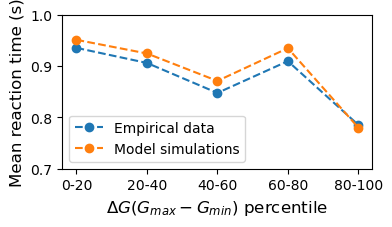

In [52]:
plt.figure(figsize=(4, 2))
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_empirical_rts_AI_ddm, label='Empirical data', linestyle='--', marker='o')
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_simulated_rts_AI_ddm, label= 'Model simulations', linestyle='--', marker='o')
plt.ylabel("Mean reaction time (s)" , fontsize=12)
plt.xlabel(r"$\Delta G (G_{max} - G_{min})$ percentile", fontsize=12)
plt.ylim(0.7,1)
plt.legend() 
plt.show()

In [53]:
mean_empirical_rts_AI_ddm = [
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['empirical_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['empirical_rts_stage_1']) 
]

mean_simulated_rts_AI_ddm = [
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['average_simulated_rts_stage_1']),
    np.mean(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['average_simulated_rts_stage_1']) 
]

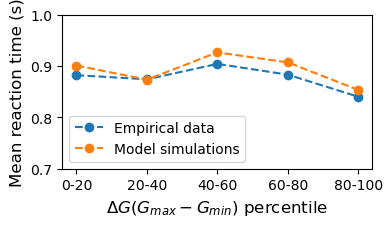

In [54]:
plt.figure(figsize=(4, 2))
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_empirical_rts_AI_ddm, label='Empirical data', linestyle='--', marker='o')
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_simulated_rts_AI_ddm, label= 'Model simulations', linestyle='--', marker='o')
plt.ylabel("Mean reaction time (s)" , fontsize=12)
plt.xlabel(r"$\Delta G (G_{max} - G_{min})$ percentile", fontsize=12)
plt.ylim(0.7,1)
plt.legend() 
plt.show()

In [55]:
mean_empirical_choice_AI_ddm_stage_1 = [
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])
]

mean_simulated_choice_AI_ddm_stage_1 = [
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['simulated_prob_min_EFE_action_stage_1']),
]



In [86]:
mean_empirical_choice_AI_stage_1 = [
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])
]

mean_simulated_choice_AI_stage_1 = [
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "0-20"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "20-40"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "40-60"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "60-80"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_1_percentile"] == "80-100"]['simulated_prob_min_EFE_action_stage_1']),
]


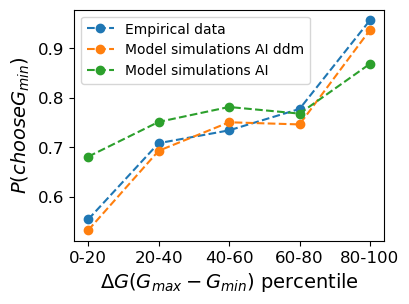

In [91]:
plt.figure(figsize=(4, 3))

plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_empirical_choice_AI_ddm_stage_1,label='Empirical data', linestyle='--', marker='o')
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_simulated_choice_AI_ddm_stage_1, label= 'Model simulations AI ddm', linestyle='--', marker='o')
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_simulated_choice_AI_stage_1, label= 'Model simulations AI', linestyle='--', marker='o')
plt.ylabel(r"$P(choose G_{min})$" , fontsize=14)
plt.xlabel(r"$\Delta G (G_{max} - G_{min})$ percentile", fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # Adjust labelsize as needed
plt.legend() 
plt.show()

In [57]:
mean_empirical_choice_stage_0 = [
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])
]

mean_simulated_choice_stage_0 = [
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['simulated_prob_min_EFE_action_stage_1']),
]



In [88]:
mean_empirical_choice_stage_0_AI = [
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['empirical_min_EFE_action_stage_1']),
    np.sum(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])/len(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['empirical_min_EFE_action_stage_1'])
]

mean_simulated_choice_stage_0_AI = [
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "0-20"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "20-40"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "40-60"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "60-80"]['simulated_prob_min_EFE_action_stage_1']),
    np.average(df_delta_G[df_delta_G["delta_G_0_percentile"] == "80-100"]['simulated_prob_min_EFE_action_stage_1']),
]


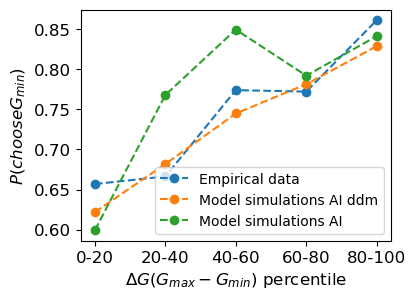

In [92]:
plt.figure(figsize=(4, 3))
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_empirical_choice_stage_0, label='Empirical data', linestyle='--', marker='o')
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_simulated_choice_stage_0, label= 'Model simulations AI ddm', linestyle='--', marker='o')
plt.plot(["0-20","20-40","40-60","60-80","80-100"], mean_simulated_choice_stage_0_AI, label= 'Model simulations AI', linestyle='--', marker='o')
plt.ylabel(r"$P(choose G_{min})$" , fontsize=12)
plt.xlabel(r"$\Delta G (G_{max} - G_{min})$ percentile", fontsize=12)
plt.tick_params(axis='both', labelsize=12)  # Adjust labelsize as needed
plt.legend() 
plt.show()

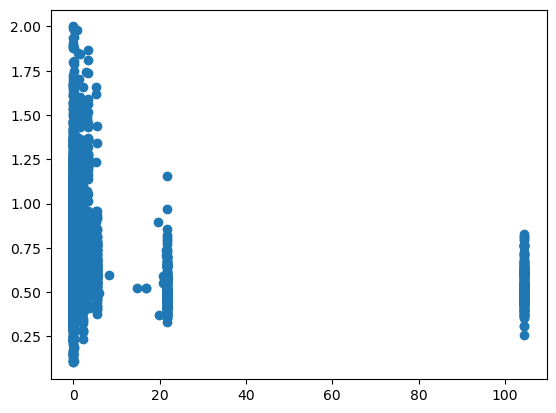

In [59]:
plt.scatter(df_delta_G["KL_0"],df_delta_G["empirical_rts_stage_0"])
#plt.xlim(0,25)

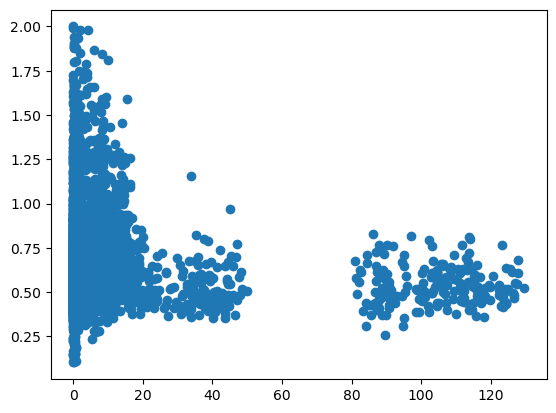

In [60]:
plt.scatter(df_delta_G["delta_G_0"], df_delta_G["empirical_rts_stage_0"])
#plt.ylim(0,10)

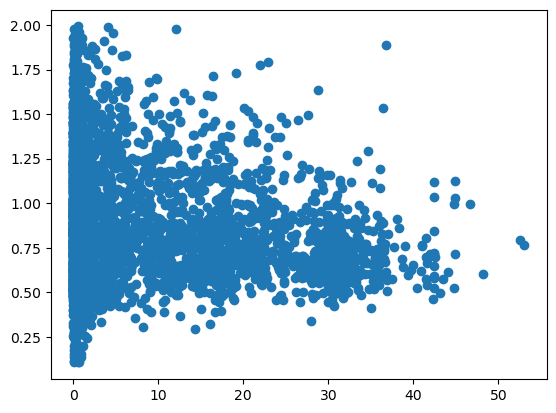

In [61]:
plt.scatter(df_delta_G["delta_G_1"], df_delta_G["empirical_rts_stage_1"])

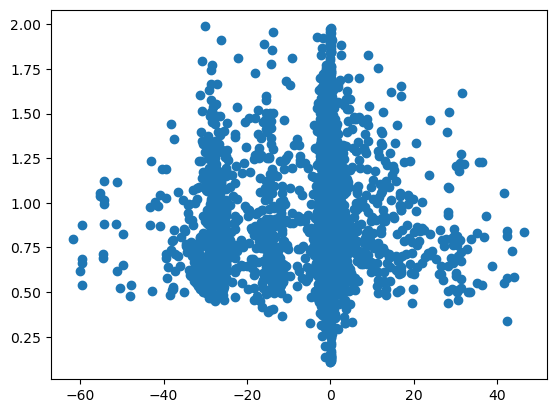

In [62]:
plt.scatter(df_delta_G["KL_1"], df_delta_G["empirical_rts_stage_1"])